# Inception and Support Vector Machine on CIFAR-10 dataset

We start our work with import of all python libraries, frameworks and classes needed.

In [1]:
import pandas as pd
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from skimage.feature import hog
from skimage import color
from itertools import product
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

/home/agnieszka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Data download and visualization

We use Keras to download CIFAR-10 dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# We transform labels (y_train, y_test) to be 1d arrays:
y_train = y_train.flatten() 
y_test = y_test.flatten()

For the purposes of data visualization and training shallow classifier it is more convienient to store data in pandas.DataFrame() objects.

In [3]:
data_train = pd.DataFrame()
data_train['images']=pd.Series(list(x_train))
data_train['labels']=pd.Series(y_train)

data_test = pd.DataFrame()
data_test['images']=pd.Series(list(x_test))
data_test['labels']=pd.Series(y_test)

We choose 10 random images from each class and display them in 10x10 grid.

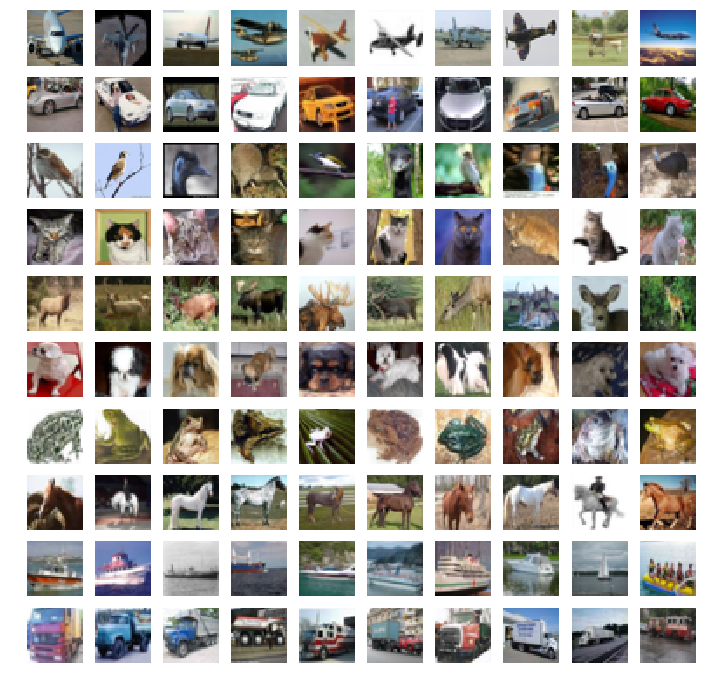

In [4]:
to_print=[None]*10
for i in range(10):
    to_print[i] = data_train[data_train.labels==i].sample(10).images.reset_index(drop=True)

_, axs = plt.subplots(10,10, figsize=(12,12))

for i,j in product(range(10),repeat=2):
    axs[i,j].imshow(to_print[i][j])
    axs[i,j].axis('off')

## 2. Shallow classifier

Before training classifier, we preprocess input data using feature extraction. We choose HoG (histogram of oriented gradients).

In [5]:
# define a function that given array of an image transform it to feature vector
def hog_feat(array):
    return hog(color.rgb2gray(array), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(4, 4))

# Apply function hog_feat to image columns in data_train and data_test data frames 
# and store results in columns named 'hog_features'
data_train['hog_features'] = data_train.images.apply(hog_feat)
data_test['hog_features'] = data_test.images.apply(hog_feat)

/home/agnieszka/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Now, we standardize our feature vectors using StandardScaler(). Support Vector Classifier chosen for this task performs better when sets of values of each feature have the same mean and variance. After that we train LinearSVC() with default parameters on standardized feature vectors of training images. We also make predictions on test set and store them in 'pred_shallow' variable.

In [6]:
scaler = StandardScaler()
scaler.fit(np.vstack(data_train.hog_features))
X_train = scaler.transform(np.vstack(data_train.hog_features))
X_test = scaler.transform(np.vstack(data_test.hog_features))

model = LinearSVC()
model.fit(X_train, y_train)
pred_shallow = model.predict(X_test)
acc_0 = accuracy_score(pred_shallow, y_test)

/home/agnieszka/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Calculate accuracy:

In [7]:
print('Accuracy on test set:', acc_0)

Accuracy on test set: 0.4432


We see that chosen shallow classifier (HoG + LinearSVC) performs poorly on CIFAR-10 classification problem.  

We visualize results using confusion matrix displayed as a heatmap. Vertically, we have uppercase names of classes from dataset. Horizontally, we see lowercase names of classes predicted by classifier. Numbers in squares inform what fraction of class 'a' (row) was classified as class 'b' (column).

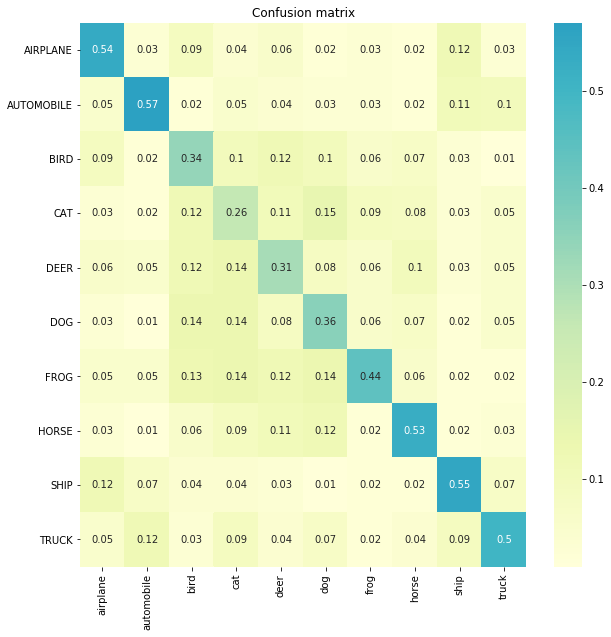

In [8]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
LABELS = [i.upper() for i in labels]

cm = confusion_matrix(pred_shallow, y_test)
cm = (cm.astype('float') / cm.sum(axis=1)).round(2)
plt.figure(figsize=(10,10))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap='YlGnBu', center=0.5, xticklabels=labels, yticklabels=LABELS)
plt.show()

## 3. InceptionV3 feature extraction

Due to very limited computational power of my personal computer I decided to use Google Cloud Platform with CUDA-enabled GPU for neural network computations. 

Script which extracts features of images is in 'extract_features.py' file attached to this repository. I used Keras API with Tensorflow backend. Keras is easy to use and provides all the functionalities needed for the task.   
With the code lines:

from keras.applications.inception_v3 import InceptionV3  
model_inc = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

we create a InceptionV3 network model with weights from ImageNet, without top dense layer and with last global pooling layer.

After running model.predict() on our train and test images we obtain 2048-feature vector for each image. We store feature vectors in 'codes_train.pkl' and 'codes_test.pkl' 

File 'flip_extract_features.py' contains script that perform data augmentation on train set, specifically, mirror reflection of images. The reason we choose this method is that mirror reflection of a cat is still a valid image of a cat. We cannot say this about rotations. Script computes feature vectores of images using Inception network and save them to 'code_train_flip.pkl' file.

## 4. 2d visualization of CNN-codes

We use t-SNE method to visualize CNN codes of test set images in 2-dimmensional space. We mark different classes with different colors. Points representing images from the same class have the same color.

In [9]:
# load CNN codes from a file
with open('/home/agnieszka/codes_test.pkl', 'rb') as codes:
    codes_test = pickle.load(codes)

In [10]:
points_2d = TSNE(2).fit_transform(codes_test)

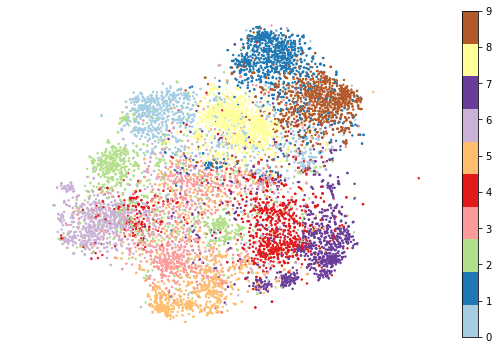

In [11]:
plt.figure(figsize=(9,6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=y_test, cmap=plt.cm.get_cmap("Paired", 10), s=2)
plt.colorbar(ticks=range(10))
plt.axis('off')
plt.show()

## 5. Hyperparameter tuning and training classifiers

We try 4 approaches to the problem of finding best classifier for CIFAR-10 dataset. All of then involve feature extraction using InceptionV3 pre-trained network and support vector machine for classification. We also use GridSearchCV to find best choice of hyperparameters for given grid of parameters.
It was more convienient to perform computations on Google Cloud server, since we could work parallelly on 24 CPUs. We included python files, which were run in the cloud. Best models found by those scripts were saved in .sav files.

1. **cifar-inc.py**  
SVC performs computation on CNN codes.  
Best model file: *best_model.sav*
2. **cifar-inc-st.py**  
CNN codes are standardized before going to SVC.  
Best model file: *best_model_st.sav*
3. **cifar-inc-st-aug.py**  
We use data augmentation (mirror reflection) of training data, we standardize the data and then apply SVC.  
Best model file: *best_model_st_aug.sav*
4. **cifar-inc-st-bagg.py**  
We standardize data, then we build BaggingClassifier using SVC as a base_estimator.  
Best model file: *best_model_st_bagg.sav*

## 6. Results analysis

We load best models found by GridSearchCV.

In [12]:
with open('/home/agnieszka/best_model.sav', 'rb') as model:
    best_model = pickle.load(model)
    
with open('/home/agnieszka/best_model_st.sav', 'rb') as model:
    best_model_st = pickle.load(model)
    
with open('/home/agnieszka/best_model_st_aug.sav', 'rb') as model:
    best_model_st_aug = pickle.load(model)
    
with open('/home/agnieszka/best_model_st_bagg.sav', 'rb') as model:
    best_model_st_bagg = pickle.load(model)

We print parameters' values for each of models.

In [13]:
print('Best_model: kernel = {}, gamma = {}, C = {}'.format(best_model.kernel, best_model.gamma, best_model.C))
print('Best_model_st: kernel = {}, gamma = {}, C = {}'\
      .format(best_model_st.named_steps['model'].kernel, best_model_st.named_steps['model'].gamma,\
              best_model_st.named_steps['model'].C))
print('Best_model_st_aug: kernel = {}, gamma = {}, C = {}'\
      .format(best_model_st_aug.named_steps['model'].kernel, best_model_st_aug.named_steps['model'].gamma,\
              best_model_st_aug.named_steps['model'].C))
print('Best_model_st_bagg: kernel = {}, gamma = {}, C = {}, max_features = {}, max_samples = {}'\
      .format(best_model_st_bagg.named_steps['model'].base_estimator.kernel,\
              best_model_st_bagg.named_steps['model'].base_estimator.gamma,\
              best_model_st_bagg.named_steps['model'].base_estimator.C,\
              best_model_st_bagg.named_steps['model'].max_features, best_model_st_bagg.named_steps['model'].max_samples))

Best_model: kernel = rbf, gamma = scale, C = 10
Best_model_st: kernel = rbf, gamma = scale, C = 10
Best_model_st_aug: kernel = rbf, gamma = scale, C = 50
Best_model_st_bagg: kernel = rbf, gamma = scale, C = 10, max_features = 0.5, max_samples = 0.5


Having best models found by GridSearchCV let us use them to compute predictions for our test set.

In [14]:
pred_1 = best_model.predict(codes_test)
pred_2 = best_model_st.predict(codes_test)
pred_3 = best_model_st_aug.predict(codes_test)
pred_4 = best_model_st_bagg.predict(codes_test)

Now compute accuracy scores for our models.

In [15]:
acc_1 = accuracy_score(pred_1, y_test)
acc_2 = accuracy_score(pred_2, y_test)
acc_3 = accuracy_score(pred_3, y_test)
acc_4 = accuracy_score(pred_4, y_test)

Create a benchmark data frame for our models' performance.

In [16]:
table = pd.DataFrame(columns=['Accuracy on the test set (%)'])
table.loc['HoG + StandardScaler + LinearSVC'] = acc_0*100
table.loc['InceptionV3 + SVM(kernel = {}, gamma = {}, C = {})'.format(best_model.kernel, best_model.gamma, best_model.C)]=acc_1*100
table.loc['InceptionV3 + StandardScaler + SVM(kernel = {}, gamma = {}, C = {})'\
         .format(best_model_st.named_steps['model'].kernel, best_model_st.named_steps['model'].gamma,\
                 best_model_st.named_steps['model'].C)]=acc_2*100
table.loc['DataAug + InceptionV3 + StandardScaler + SVM(kernel = {}, gamma = {}, C = {})'\
         .format(best_model_st_aug.named_steps['model'].kernel, best_model_st_aug.named_steps['model'].gamma,\
                 best_model_st_aug.named_steps['model'].C)]=acc_3*100
table.loc['InceptionV3 + StandardScaler + Bagging(max_features = {}, max_samples = {}) + SVM(kernel = {}, gamma = {}, C = {})'\
          .format(best_model_st_bagg.named_steps['model'].max_features, best_model_st_bagg.named_steps['model'].max_samples,\
                  best_model_st_bagg.named_steps['model'].base_estimator.kernel,\
                  best_model_st_bagg.named_steps['model'].base_estimator.gamma,\
                  best_model_st_bagg.named_steps['model'].base_estimator.C)]=acc_4*100
table

,Accuracy on the test set (%)
HoG + StandardScaler + LinearSVC,44.32
"InceptionV3 + SVM(kernel = rbf, gamma = scale, C = 10)",86.69
"InceptionV3 + StandardScaler + SVM(kernel = rbf, gamma = scale, C = 10)",87.51
"DataAug + InceptionV3 + StandardScaler + SVM(kernel = rbf, gamma = scale, C = 50)",87.88
"InceptionV3 + StandardScaler + Bagging(max_features = 0.5, max_samples = 0.5) + SVM(kernel = rbf, gamma = scale, C = 10)",86.01


The best results were obtained for classification algorithm that combines data augmentation, Inception network, standardizing CNN codes and using support vector classifier with kernel='rbf', gamma='scale' and C=50. We display confusion matrix for classifier 'best_model_st_aug' to see what kind of errors is the most common.

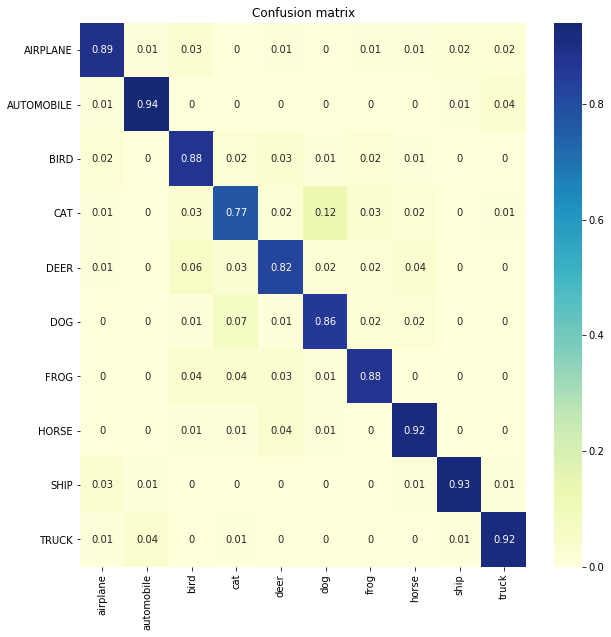

In [17]:
cm = confusion_matrix(pred_3, y_test)
cm = (cm.astype('float') / cm.sum(axis=1)).round(2)
plt.figure(figsize=(10,10))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap='YlGnBu', center=0.5, xticklabels=labels, yticklabels=LABELS)
plt.show()

We can see that some classes are easier to classify then others. Over 90% of images of automobiles, horses, ships and trucks are correctly classified by the model. On the other hand, we have cats of which only 77%  were recognized by the algorithm and 12% of cats are classified as dogs. The way to improve performance on cats images may be adding more images of cats to training set, e.g. using another data augmentation technique like adding random noise to cats images.  

Interesting thing is that animals almost always are classified as animals and 'transportation machines' almost always as 'transportation machines'. 

## Can we do better?

Due to time limits and computational power constraints we were able to analyse only small set of hyperparameters in GridSearchCV. Next step could be checking parameters close to those chosen by GridSearchCV. It would be worth to check whether building large parameter grid and searching for best model using RandomizedSearchCV can lead to better performance. We could also repeat analysis using different pre-trained network.